# Assignment 1 - SIR model (ODE)
## Student: Boyan Mihaylov

This notebook contains the code used in conducting the experiments and obtaining the results described in the report for Assignment 1 of the course "Introduction to Computational Science".

### 1. Prerequisites

The following code imports the relavant libraries for the calculations:

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

The Fourth order Runge-Kutta method [1](#references) will be implemented as default numerical integration scheme:

In [2]:
def runge_kutta(fun, x, step):
        
        k1 = fun(x)*step
        k2 = fun(x+0.5*k1)*step
        k3 = fun(x+0.5*k2)*step
        k4 = fun(x+k3)*step
        return x + (k1+2*k2+2*k3+k4)/6

### 2. The SIR Class

Next the SIR model is defined as a Python class called `InfectionModel`, which will contain all the relevant input data for a specific disease, so that the outcomes of different diseases can be easily compared.

### 2.1. Initialization Function
At the initialization of the class, the values of $\beta$ (infection rate) and $\gamma$ (recovery rate) which will be used in the further calculations can be derived from "real-life" values as described in [2](#references) (p.17-18). Alternatively, these can be supplied directly to the system.

The definitions are as follows:

$\beta = -\kappa ln(1-C)$, where $\kappa$ is the number of individual contacts per unit time and $C$ is the probability of infection in the case of an infected contact.

$\gamma = 1/P_{inf}$ where $P_{inf}$ is the period of infection.

The parameters $k$, $C$ and $P_{inf}$ will be written down in the code as `k`, `c` and `pinf` respectively.

The basic reproductive ratio $R_0$ is defined such that $R_0=\frac{\beta}{\gamma}$.

Additionally, the population data will be initialized in the same function. The number of susceptible individuals $X$, infected ones $Y$ and recovered ones $Z$ will be available as optional arguments, which can either be user-defined or follow default values. The sum of the three quantities forms the population size $N$ and all of these values are then used to calculate the proportions of susceptibles $S$, infected $I$ and recovered $R$.

### 2.2. Differential equations
The system of differential equations governing the dynamics of the model will be defined in a special function called `SIR_nd` standing for "SIR model, no demography", which iterates over the class-specific $S$, $I$ and $R$ variables, updates and returns their corresponding derivatives.

This module is created with the purpose to be exchanged in case a different dynamic system is to be used. The current equations are:

$$
\frac{dS}{dt}=-\beta S I\\
\frac{dI}{dt}= \beta S I - \gamma I\\
\frac{dR}{dt}= \gamma I
$$

The function for the differential equations is stored as a class variable upon initialization.

In [3]:
class InfectionModel:
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, beta=None, gamma=None):
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta and gamma depending on inputs
        if beta:
            self.beta=beta
        else:
            self.beta = -k*math.log(1-c)
        if gamma:
            self.gamma = gamma
        else:
            self.gamma = 1/pinf
        self.R0 = self.beta/self.gamma
        
        self.N = X+Y+Z
        self.S = X/self.N
        self.I = Y/self.N
        self.R = Z/self.N
        
        self.ode = self.SIR_nd
        
    def SIR_nd(self, sir):
        
        self.dS = -self.beta*sir[0]*sir[1]
        self.dI = self.beta*sir[0]*sir[1] - self.gamma*sir[1]
        self.dR = self.gamma*sir[1]
        
        return np.array([self.dS, self.dI, self.dR])
    
    def iterate(self, step, max_time, beta=None, gamma=None):
        
        # Assign native beta and gamma unless overriden
        if beta:
            self.beta = beta
        else:
            beta = self.beta
        if gamma:
            self.gamma = gamma
        else:
            gamma = self.gamma
        
        S_log = []
        I_log = []
        R_log = []
        time_log = []
        
        time_elapsed = 0
        while time_elapsed < max_time:
            S_log.append(self.S)
            I_log.append(self.I)
            R_log.append(self.R)
            time_log.append(time_elapsed)
            self.S, self.I, self.R = runge_kutta(self.ode, np.array([self.S,self.I,self.R]),step)
            time_elapsed += step
        
        return S_log, I_log, R_log, time_log
    

### 3. Execution without demography

Next an instance of the InfectionModel class is created, which would be predisposed to the development of an epidemic. The chosen parameters for this experiments are:
$$
\kappa = 8\\
C = 0.1\\
P_{inf} = 7
$$

The development of the disease represented by the model is plotted over a time period of 90 days.

gamma: 0.14285714285714285
beta: 0.8428841252626103
R0: 5.900188876838272


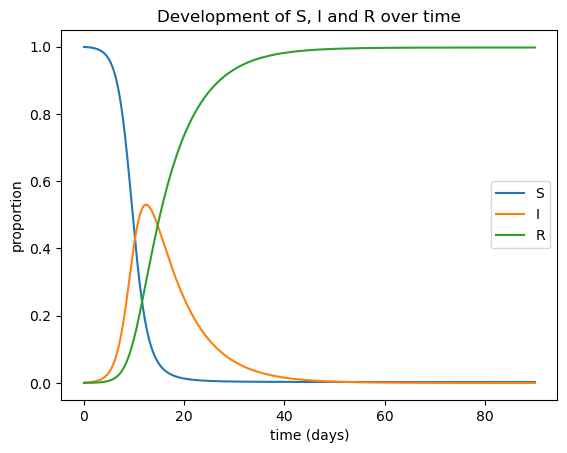

In [4]:
SIR = InfectionModel(k=8, c=0.1, pinf=7)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))

# Iteration step
step = 10e-3

# Time in days
max_time = 90

# Perform numerical integration
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

The phase space diagrams at different starting values of $S$ and $I$ are plotted by the following code:

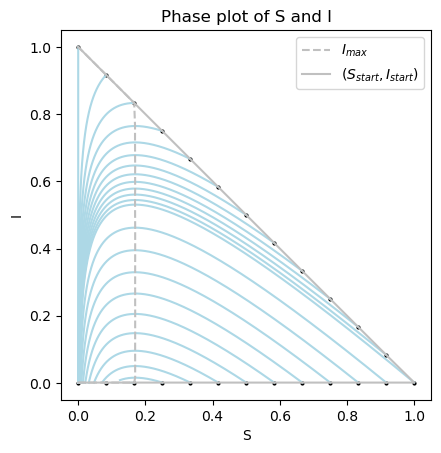

In [53]:
num_plots = 25
base_population = 1000
increment = base_population/(num_plots-1)

# Track maximum of I
I_max = []

# Track level of S at which I is maximum
S_atmax = []

# Track starting values of S and I
S_starts = []
I_starts = []

for x in range(num_plots):
    
    # Time in days
    max_time = 90
    time_elapsed = 0
    
    # Determine starting conditions:
    # for first half of the plots - increment X, Y = 1, Z = N - X - 1
    # for second half of the plots - increment Y, X = N - Y, Z = 0
    if x <= num_plots*0.5:
        X_start = x*increment*2
        Y_start = 1
        Z_start = base_population-x*increment*2-1
    else:
        X_start = base_population-(x-math.floor(num_plots*0.5))*increment*2
        Y_start = (x-math.floor(num_plots*0.5))*increment*2
        Z_start = 0
    
    # Initialize infection model
    SIR = InfectionModel( X_start, Y_start, Z_start, 8, 0.1, 7)
    
    # Append starting points and mark their positions
    S_starts.append(SIR.S)
    I_starts.append(SIR.I)
    plt.plot(SIR.S,SIR.I,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})
    
    # Track development of infection over time
    S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)
    
    # Track maxima of infection values
    I_max.append(max(I_log))
    S_atmax.append(S_log[np.argmax(I_log)])
    
    # Plot infection values
    ax = plt.subplot()
    ax.plot(S_log, I_log,color='lightblue')
    ax.set_aspect('equal','box')
    plt.xlabel('S')
    plt.ylabel('I')
    plt.title('Phase plot of S and I')

# Plot maxima and starting points
ax.plot(S_atmax, I_max,linestyle='dashed',color='silver',label='$I_{max}$')
ax.plot(S_starts, I_starts,color='silver', label='$(S_{start},I_{start})$')
ax.legend()
plt.show()

An alternative set of parameters would guarantee that no epidemic would develop. These should ultimately result in a $R_0$ value smaller than 1, which applies for a sufficiently small $\beta$. This can be influenced by setting the infection probablitity $C$ to a very small number.

To calculate the threshold value for $C$ while keeping the other variables fixed, the equation for $R_0$ can be rewritten:

$$
R_0 = \frac{\beta}{\gamma} = \frac{-\kappa ln(1-C)}{\gamma} \\
\gamma R_0 = -\kappa ln(1-C) \\
ln(1-C)=-\frac{\gamma R_0}{\kappa}
C = 1 - e^{-\frac{\gamma R_0}{\kappa}}
$$

For $\gamma = 1/7$ and $\kappa = 8$ and $R_0 = 1$ this equates to:

$$
C \approx 0.017699
$$

Which implies approximately 1.77% probability for infection given contact with an infected person.

gamma: 0.14285714285714285
beta: 0.12090910248038547
R0: 0.8463637173626983


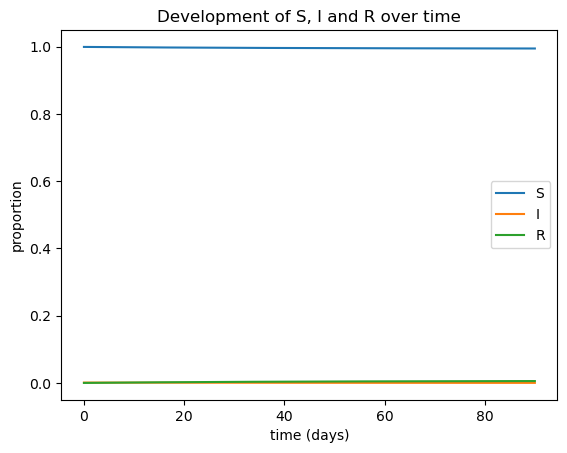

In [25]:
SIR = InfectionModel(k=8, c=0.015, pinf=7)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))

# Iteration step
step = 10e-3

# Time in days
max_time = 90

# Perform numerical integration
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

The phase plot can be checked for verification:

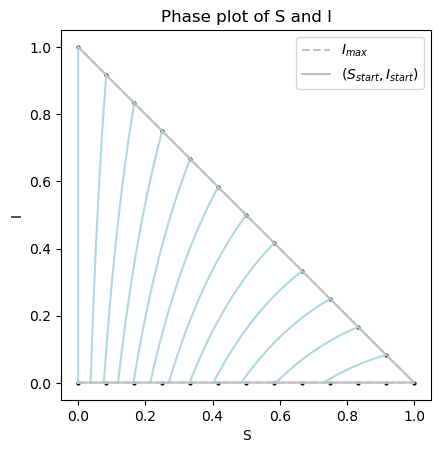

In [50]:
num_plots = 25
base_population = 1000
increment = base_population/(num_plots-1)

# Track maximum of I
I_max = []

# Track level of S at which I is maximum
S_atmax = []

# Track starting values of S and I
S_starts = []
I_starts = []

for x in range(num_plots):
    
    # Time in days
    max_time = 90
    time_elapsed = 0
    
    # Determine starting conditions:
    # for first half of the plots - increment X, Y = 1, Z = N - X - 1
    # for second half of the plots - increment Y, X = N - Y, Z = 0
    if x <= num_plots*0.5:
        X_start = x*increment*2
        Y_start = 1
        Z_start = base_population-x*increment*2-1
    else:
        X_start = base_population-(x-math.floor(num_plots*0.5))*increment*2
        Y_start = (x-math.floor(num_plots*0.5))*increment*2
        Z_start = 0
    
    # Initialize infection model
    SIR = InfectionModel(X_start, Y_start, Z_start, 8, 0.015, 7)
    
    # Append starting points and mark their positions
    S_starts.append(SIR.S)
    I_starts.append(SIR.I)
    plt.plot(SIR.S,SIR.I,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})
    
    # Track development of infection over time
    S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)
    
    # Track maxima of infection values
    I_max.append(max(I_log))
    S_atmax.append(S_log[np.argmax(I_log)])
    
    # Plot infection values
    ax = plt.subplot()
    ax.plot(S_log, I_log,color='lightblue')
    ax.set_aspect('equal','box')
    plt.xlabel('S')
    plt.ylabel('I')
    plt.title('Phase plot of S and I')

# Plot maxima and starting points
ax.plot(S_atmax, I_max,linestyle='dashed',color='silver',label='$I_{max}$')
ax.plot(S_starts, I_starts,color='silver', label='$(S_{start},I_{start})$')
ax.legend()
plt.show()

As expected, all initial states with nonzero $I$ flow almost directly to zero without forming a peak in between.

### 4. Fitting of the SIR model

The data from the influenza outbreak case is saved in an array called `cases`. The data entries represent the number of infected individuals $Y$ and can be plotted against the time of infection:

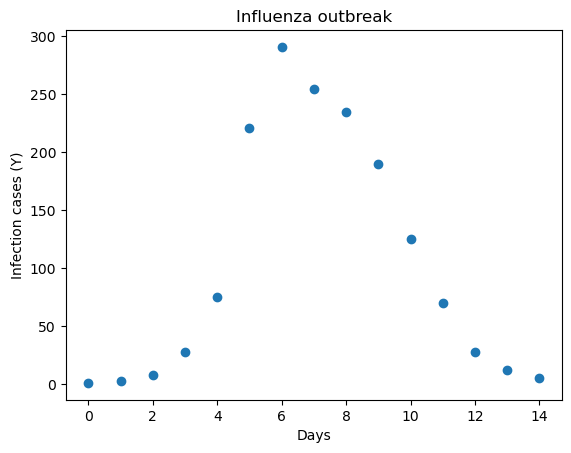

In [6]:
cases = np.array([1,3,8,28,75,221,291,255,235,190,125,70,28,12,5])

days = np.arange(0,15,1)

plt.scatter(days, cases)
plt.xlabel('Days')
plt.ylabel('Infection cases (Y)')
plt.title('Influenza outbreak')
plt.show()

To fit an objective function to the data points, the `scipy.optimize.curve_fit` function will be used.

To enable the implementation of the `InfectionModel` class' `iterate` function, a new class `Tester` is defined, which evaluates the integration only using the necessary parameters for the curve fitting.

R0: 3.716749928047735


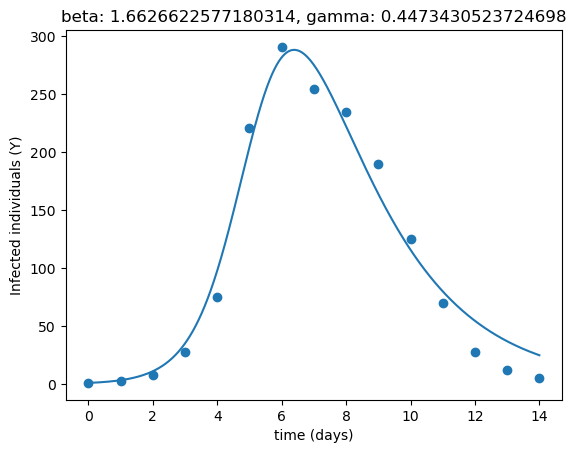

In [7]:
class Tester:
    
    def __init__(self, step, X, Y, Z):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = X+Y+Z
        
        self.max_time = max_time
        self.step = step
        
    def create_model_and_test(self, times, beta, gamma):

        # Create instance with hard-coded population values and given beta and gamma
        SIR_fit = InfectionModel(self.X,self.Y,self.Z,beta=beta,gamma=gamma)
        
        # Iterate ODEs using last time as duration
        _, infected, _, times_out = SIR_fit.iterate(self.step, times[-1]+1)
        
        # Get a sample of the infected indivisuals only for the given days
        infected_sample = []
        times_ct = 0 # counter
        for i in range(len(times_out)):
            if times_out[i] >= times[times_ct]:
                infected_sample.append(infected[i]*self.N)
                times_ct += 1
                if times_ct >= len(times):
                    break

        return infected_sample

    
# Initial conditions from data
X_start = 762
Y_start = 1
Z_start = 0
N = X_start+Y_start+Z_start
    
tester = Tester(step, X_start, Y_start, Z_start)

params_fit, _ = scipy.optimize.curve_fit(tester.create_model_and_test, days, cases, p0 = [1.8,0.1], bounds = ([0,0],[100,100]), method='trf')

beta_fit, gamma_fit = params_fit

# Recalculate model with fitted parameters
SIR_fitted = InfectionModel(X_start, Y_start, Z_start,beta=beta_fit,gamma=gamma_fit)
S_log, I_log, R_log, time_log = SIR_fitted.iterate(step, days[-1])
print("R0: " + str(SIR_fitted.R0))

# Rescale to population size
Y_log = np.multiply(I_log, N)

# Plot original data points with I-curve of fitted model
plt.scatter(days, cases)
plt.plot(time_log, Y_log,label='Y')
plt.xlabel('time (days)')
plt.ylabel('Infected individuals (Y)')
plt.title('beta: ' + str(beta_fit) + ", gamma: " + str(gamma_fit))
plt.show()

Therefore, the estimated parameters for the infection are $\beta=\approx1.6627$, $\gamma=\approx0.4473$ and, respectively, $R_0\approx3.7167$.

### 5. Vaccination strategy simulations

### 6. SIR model with demography

To incorporate demography into the model, an extension of the class `InfectionModel` called `InfectionModelDemography` is defined, which implements the new equations taking into account the birth/death rate $\mu$.

The new model now incorporates the following ODEs:

$$
\frac{dS}{dt}=\mu-\beta S I - \mu S \\
\frac{dI}{dt}=\beta S I - \gamma I - \mu I \\
\frac{dR}{dt}=\gamma I - \mu R
$$

$\mu$ can either be supplied explicitly, or calculated from the inverse of an average human lifespan, when provided.

$R_0$ is also redefined to incorporate the demographics parameter, so that $R_0=\frac{\beta}{\gamma+\mu}$.

In [8]:
class InfectionModelDemography(InfectionModel):
    
    # Extends __init__() with mu
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        super(InfectionModelDemography, self).__init__(X, Y, Z, k, c, pinf, beta, gamma)
        if mu:
            self.mu = mu
        else:
            self.mu = 1/lifespan
        
        self.R0 = self.beta/(self.gamma+self.mu)
        self.ode = self.SIR_d
    
    # Adds ODEs for demography model
    def SIR_d(self, sir):
        
        self.dS = self.mu - self.beta*self.S*self.I - self.mu*self.S
        self.dI = self.beta*self.S*self.I - self.gamma*self.I - self.mu*self.I
        self.dR = self.gamma*self.I - self.mu*self.R
        
        return np.array([self.dS, self.dI, self.dR])

The dynamics of the system are printed using the same time period and step size as the previous model. $\mu$ is in this case based on the meadian age in the EU for 2022, which is 44.1 years, or translated in days: $44.1*(365*3+366)/4=16107.525$.

Due to the time-scale difference between the recovery rate and the birth/death rate, the oscillations in the system only become visible over a longer observed time period - about 10 years in this case.

Furthermore, the infection probablitity is increased to 0.6 to amplify the oscillations.

gamma: 0.14285714285714285
beta: 5.545177444479562
R0: 38.79938069628082
mu: 6.208278428870977e-05


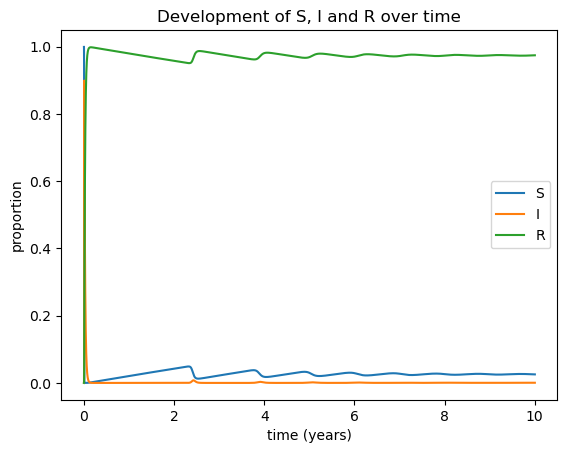

In [9]:
SIR = InfectionModelDemography(k=8, c=0.5, pinf=7, lifespan = 16107.525)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))
print("mu: "+str(SIR.mu))

# Iteration step
step = 10e-2

# Time in days
max_time = 3653

# Terform numerical integration
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

# Scale time to years
time_log = np.multiply(time_log, 1/365.25)

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (years)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

The phase space diagrams provide a better understanding of the system's dynamics by plotting the trajectories of $S$ against $I$ over time:

beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562
beta: 5.545177444479562


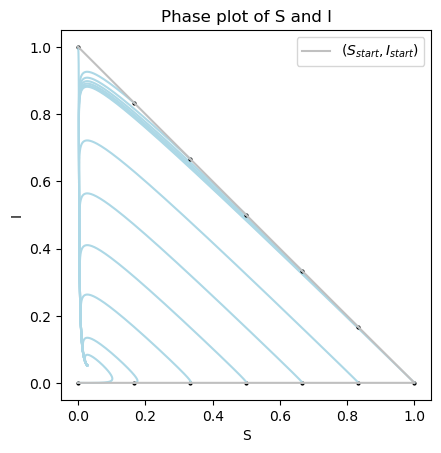

'# STREAMPLOT\n\n# grid points\nz_grid, y_grid, x_grid = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j]\n\n# grid velocities\nu_grid = 0.00006 - 5.54*x_grid*y_grid - 0.00006*x_grid\nv_grid = 5.54*x_grid*y_grid - 0.14*y_grid - 0.00006*y_grid\nw_grid = 0.14*y_grid - 0.00006*z_grid\n\n\nplt.title("(R^2)*C−4L=0")\nplt.streamplot(x_grid, y_grid, u_grid, v_grid)\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.show()'

In [55]:
num_plots = 13
base_population = 1000
increment = base_population/(num_plots-1)

# Track maximum of I
I_max = []

# Track level of S at which I is maximum
S_atmax = []

# Track starting values of S and I
S_starts = []
I_starts = []

for x in range(num_plots):
    
    # Time in days
    max_time = 3653
    time_elapsed = 0
    
    # Determine starting conditions:
    # for first half of the plots - increment X, Y = 1, Z = N - X - 1
    # for second half of the plots - increment Y, X = N - Y, Z = 0
    if x <= num_plots*0.5:
        X_start = x*increment*2
        Y_start = 1
        Z_start = base_population-x*increment*2-1
    else:
        X_start = base_population-(x-math.floor(num_plots*0.5))*increment*2
        Y_start = (x-math.floor(num_plots*0.5))*increment*2
        Z_start = 0
    
    # Initialize infection model
    SIR = InfectionModelDemography(X_start, Y_start, Z_start, k=8, c=0.5, pinf=7, lifespan = 16107.525)
    print("beta: "+str(SIR.beta))
    SIR.mu = 1/120
    #SIR.beta = 20.
    #SIR.gamma = 1/7.
    
    # Append starting points and mark their positions
    S_starts.append(SIR.S)
    I_starts.append(SIR.I)
    plt.plot(SIR.S,SIR.I,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})
    
    # Track development of infection over time
    S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)
    
    # Track maxima of infection values
    #I_max.append(max(I_log))
    #S_atmax.append(S_log[np.argmax(I_log)])
    
    # Plot infection values
    ax = plt.subplot()
    ax.plot(S_log, I_log,color='lightblue')
    ax.set_aspect('equal','box')
    plt.xlabel('S')
    plt.ylabel('I')
    plt.title('Phase plot of S and I')

# Plot starting points
ax.plot(S_starts, I_starts,color='silver', label='$(S_{start},I_{start})$')
ax.legend()
plt.show()


"""# STREAMPLOT

# grid points
z_grid, y_grid, x_grid = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j]

# grid velocities
u_grid = 0.00006 - 5.54*x_grid*y_grid - 0.00006*x_grid
v_grid = 5.54*x_grid*y_grid - 0.14*y_grid - 0.00006*y_grid
w_grid = 0.14*y_grid - 0.00006*z_grid


plt.title("(R^2)*C−4L=0")
plt.streamplot(x_grid, y_grid, u_grid, v_grid)
plt.xlabel('x')
plt.ylabel('y')
plt.show()"""



<a id='references'></a>
[1] Kutta, Wilhelm - Beitrag zur näherungsweisen Integration totaler Differentialgleichungen (1901, Zeitschrift für Mathematik und Physik)

[2] Matt J. Keeling, Pejman Rohani - Modeling Infectious Diseases in Humans and Animals (2007, Princeton University Press)